# Import

In [2]:
import configparser as cp
import pandas as pd
from ast import literal_eval

from sklearn.preprocessing import normalize

import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [3]:
config = cp.RawConfigParser()
config.read(r'config.txt')

proc_file = config.get('main', 'proc_file')
speaker_concat_file = config.get('corpus', 'speaker_concat_file')
conv_concat_file = config.get('corpus', 'conv_concat_file')

In [4]:
df_processed = pd.read_csv(proc_file, index_col='Row ID')

In [5]:
# Drop messages without a clear addressee
df_processed_explode = df_processed.loc[df_processed['listeners'].notnull()]
df_processed_explode['listeners'] = df_processed_explode['listeners'].apply(literal_eval)

# Explode on the 'listeners' column
df_processed_explode = df_processed_explode.explode('listeners')

df_processed_explode = df_processed_explode.set_index(['speaker', 'listeners'])

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_14535/2563571832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_explode['listeners'] = df_processed_explode['listeners'].apply(literal_eval)


# Create speaker corpus

In [13]:
speaker_lst = list(set(df_processed['speaker'].tolist()))

text_concat_lst = []
for speaker in speaker_lst:
    msg_lst = df_processed.loc[df_processed['speaker']==speaker]['text'].tolist()
    msg_all = '\n'.join(msg_lst)
    text_concat_lst.append(msg_all)

df_speaker_concat = pd.DataFrame(list(zip(speaker_lst, text_concat_lst)), columns=['speaker', 'text_concat'])

df_speaker_concat = df_speaker_concat.sort_values(by=['speaker'])

df_speaker_concat = df_speaker_concat.reset_index().drop(columns='index')
df_speaker_concat.index.name = 'Row ID'
df_speaker_concat.index += 1

# Create conversation corpus

In [44]:
tup_lst = list(set(df_processed_explode.index.tolist()))

conv_concat_lst = []
speaker_lst = []
listener_lst = []
for tup in tup_lst:
    (speaker, listener) = tup
    msg_lst = df_processed_explode.loc[tup]['text'].tolist()
    msg_all = '\n'.join(msg_lst)
    conv_concat_lst.append(msg_all)
    speaker_lst.append(speaker)
    listener_lst.append(listener)
    
df_conv_concat = pd.DataFrame(
    list(zip(speaker_lst, listener_lst, conv_concat_lst)), 
    columns=['speaker', 'listener', 'text_concat'])

df_conv_concat = df_conv_concat.sort_values(by=['speaker', 'listener'])
df_conv_concat = df_conv_concat.reset_index().drop(columns='index')
df_conv_concat.index.name = 'Row ID'
df_conv_concat.index += 1

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_12619/2501630177.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  msg_lst = df_processed_explode.loc[tup]['text'].tolist()


# Save

In [52]:
df_speaker_concat.to_csv(speaker_concat_file)
df_conv_concat.to_csv(conv_concat_file)

# Create communication map

In [6]:
# @num_user_dct: number of times A speaks
num_user_dct = dict(df_processed.groupby('speaker').size())
speaker_lst = list(num_user_dct.keys())

In [7]:
# @num_conv_dct: number of times A speaks to B in each pair (A,B)
num_conv_dct = dict(df_processed_explode.groupby(['speaker', 'listeners']).size())
tup_lst = list(num_conv_dct.keys())

In [8]:
# @num_conv_dct_norm: normalized interactions
num_conv_lst_norm = normalize([list(num_conv_dct.values())], norm='max')[0]
num_conv_dct_norm = dict(zip(tup_lst, num_conv_lst_norm))

In [9]:
# Visualization settings
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 100

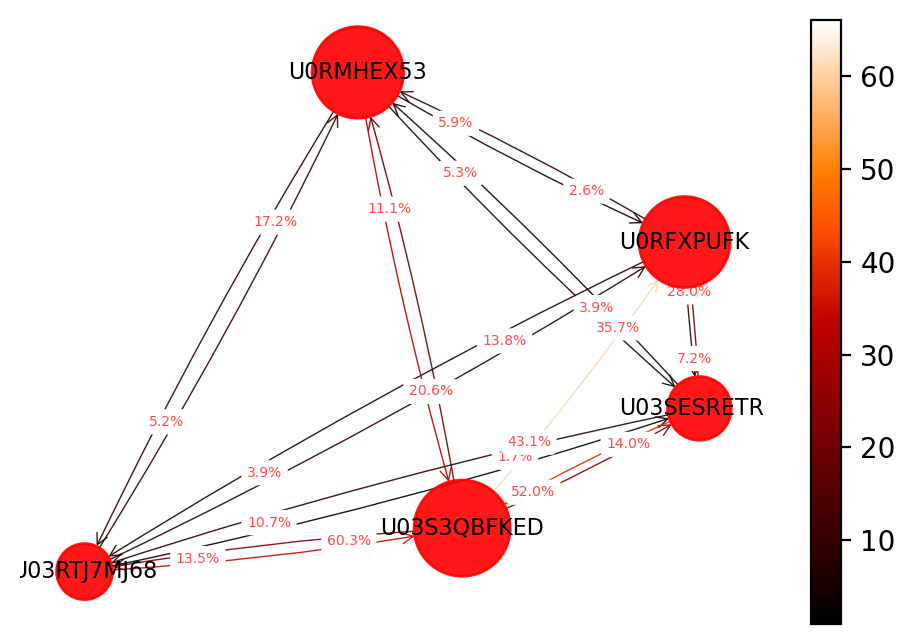

In [11]:
cmap = plt.cm.gist_heat # Color scheme


G = nx.DiGraph()

# Add nodes as speakers
node_lst = num_user_dct.keys()
G.add_nodes_from(node_lst)
    
# Add edges and weight labels
edge_lst = num_conv_dct.keys()
weight_lst = []
for (speaker, listener) in edge_lst:
    # @weigh: the amout of user A's total messages was speaking to user B
    weight = round((100 * num_conv_dct[(speaker, listener)]) / num_user_dct[speaker], 1)
    weight = str(weight)+'%'
    weight_lst.append(weight)
    G.add_edge(speaker, listener, length=weight)
    
# Spiral layout (should define layout type after creating nodes and edges)
pos = nx.spiral_layout(G)

# Node size: according to how many times user A speaks
node_sizes  = [7 * num_user_dct[node] for node in G.nodes()] # Base size=7

# Edge color darkness and transparency
edge_colors = [num_conv_dct[edge] for edge in G.edges()] # Darkness: according to how many times A speaks to B
edge_alphas = [num_conv_dct_norm[edge] for edge in G.edges()] # Transparency: acroding to normalized interactions

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G, 
    pos, 
    node_size=node_sizes, 
    node_color='r', # Node color
    alpha=0.9
)

# Draw node labels
nx.draw_networkx_labels(
    G, 
    pos, 
    labels=dict(zip(node_lst, node_lst)),
    font_size=8,
    font_color='k' # Node label (user id) color
)

# Draw edges
# nx.draw(G, with_labels=True, connectionstyle="arc3,rad=0.4")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle='->', # line instead of arrows
    # arrowsize=16,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=0.5,
    connectionstyle="arc3,rad=0.03"
)

# Set edge transparency
for i in range(len(G.edges)):
    # edges[i].set_alpha(edge_alphas[i])
    edges[i].set_alpha(0.9)
    
# Draw edge labels
nx.draw_networkx_edge_labels(
    G, 
    pos,
    edge_labels=dict(zip(edge_lst, weight_lst)),
    horizontalalignment='center',
    verticalalignment='center',
    label_pos=0.3, # how far from the head
    font_size=5,
    font_color='r',
    alpha=0.7,
    rotate=False,
)

# Draw color bar
pc = mpl.collections.PatchCollection(edges, cmap=cmap)

ax = plt.gca()
ax.set_axis_off()

pc.set_array(edge_colors)
plt.colorbar(pc, ax=ax)

# Save
plt.savefig('visual/communication_map.pdf')

In [1]:
################################################################################
##################################### END ######################################
################################################################################